# Forecasting with ML 📉

One disadvantage of using ARIMA models is that they are linear. Hence they will underfit in situations where the underlying data is of non-linear form.

One piece of recent open software is facebook's `prophet`. This uses a model which is similar to a **generalised additive model** (GAM), a class of regression models with potentially non-linear components. You can read more about this underlying model [here](https://peerj.com/preprints/3190/).

As you are beginning to see time series forecasting can sometimes be as much an art as a science, and we know it takes quite some practice to become a good artist. The authors of the software had this in mind when they wrote it.  One of their aims is to provide software which can be used easily by those who have a little timeseries knowledge. Let's see how this goes....We will apply this software to the airline data now.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates

import seaborn as sns 
import matplotlib.style as style

#!pip install pmdarima==1.5.2
import pmdarima as pmd
pmd.__version__  #should be version 1.5.2

!conda install -c conda-forge fbprophet

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                               failed

# >>>>>>>>>>>>>>>>>>>>>> ERROR REPORT <<<<<<<<<<<<<<<<<<<<<<

    Traceback (most recent call last):
      File "/home/campus-5/anaconda3/lib/python3.7/site-packages/conda/cli/install.py", line 265, in install
        should_retry_solve=(_should_retry_unfrozen or repodata_fn != repodata_fns[-1]),
      File "/home/campus-5/anaconda3/lib/python3.7/site-packages/conda/core/solve.py", line 117, in solve_for_transaction
        should_retry_solve)
      File "/home/campus-5/anaconda3/lib/python3.7/site-

In [8]:
87/63

1.380952380952381

The automatic ARIMA forecasts are prone to large trend
errors when there is a change in trend near the cutoff period and they fail to capture any
seasonality. 1 The exponential smoothing and seasonal naive forecasts capture weekly sea-
sonality but miss longer-term seasonality. All of the methods overreact to the end-of-year
dip because they do not adequately model yearly seasonality.

# Example 1 - airline data

We setup the data as we had done so before in the ARIMA example.

In [9]:
from pmdarima.datasets import load_airpassengers

START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

#there's no datetimeindex from the bundled dataset. So let's add one.
airline.index= pd.date_range(START_DATE, periods=len(airline), freq='MS')

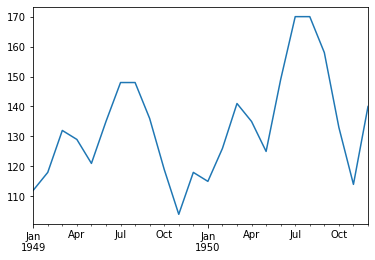

In [69]:
airline['1949':'1950'].plot()

In [10]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

In [11]:
#for cv need all of the training data joined together.
airline_adj = airline / airline.index.days_in_month

train, test = ts_train_test_split(airline_adj, '1960-01-01')
train_log, test_log = np.log(train), np.log(test) # get logged values for arima model


## Forecasting with prophet

Fitting a basic model and making predictions is very simple with `prophet`.

In [13]:
from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter

In [14]:
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters() # required to fix plotting bug introduced by prophet

Training data is expected in this df format below.

In [15]:
train_df = pd.DataFrame(train).reset_index().rename(columns = {0:'y','index':'ds'})

In [16]:
train_df.tail()

,ds,y
127,1959-08-01,18.032258
128,1959-09-01,15.433333
129,1959-10-01,13.129032
130,1959-11-01,12.066667
131,1959-12-01,13.064516


Fit model...

In [17]:
model = Prophet()
model.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Make predictions...

In [18]:
future = model.make_future_dataframe(periods=12, freq='M', include_history=True).apply(lambda x : x + pd.DateOffset(days = 1))
future.head()

,ds
0,1949-01-02
1,1949-02-02
2,1949-03-02
3,1949-04-02
4,1949-05-02


In [19]:
forecast = model.predict(future)
y_pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')

Plot predictions...

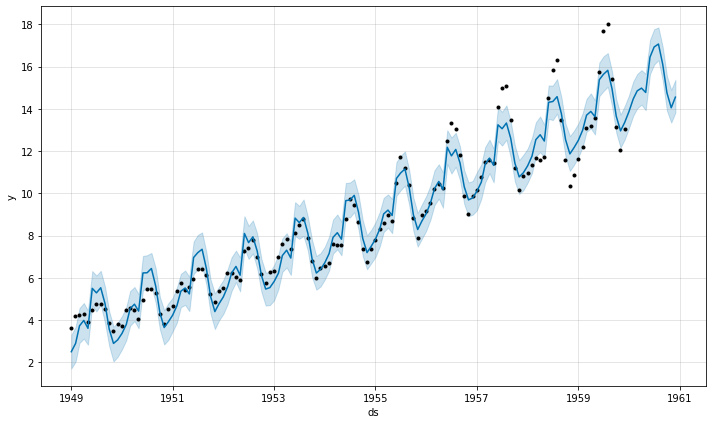

In [20]:
fig = model.plot(forecast)
# test.plot(style='.r')

Evaluating this baseline model error on test set...

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
mean_absolute_percentage_error(test.values , forecast['yhat'][-12:])

6.659792218688655

We at least see it beats the naive model scores that we saw in the last notebook. Not bad for only several lines of code. But looking at the plot it is clearly not fitting well. We should use cross validation to find a better fitting model (before we evaluated in the test set!).

## Cross validation in prophet

There are cross validation functions in `prophet` that take care of time series data and do rolling windows as we had previously seen.

In [23]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [24]:
model = Prophet()
model.fit(train_df)
df_cv = cross_validation(model, initial='1350 days', period='365 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 1952-12-02 00:00:00 and 1958-12-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1953-01-01,6.608325,6.448449,6.770056,6.322581,1952-12-02
1,1953-02-01,7.373926,7.218396,7.528812,7.000000,1952-12-02
2,1953-03-01,7.342451,7.183135,7.503921,7.612903,1952-12-02
3,1953-04-01,7.260527,7.101285,7.416594,7.833333,1952-12-02
4,1953-05-01,7.015671,6.859701,7.184565,7.387097,1952-12-02


A function for performance metrics...

In [25]:
df_p = performance_metrics(df_cv)

In [26]:
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,61 days,0.657697,0.810985,0.667030,0.075916,0.062552,0.312500
1,62 days,0.811522,0.900845,0.771085,0.081573,0.069688,0.250000
2,89 days,0.633276,0.795786,0.647987,0.069127,0.060554,0.250000
3,90 days,0.518442,0.720029,0.547247,0.052505,0.038482,0.500000
4,120 days,0.450070,0.670872,0.544906,0.056614,0.046024,0.416667


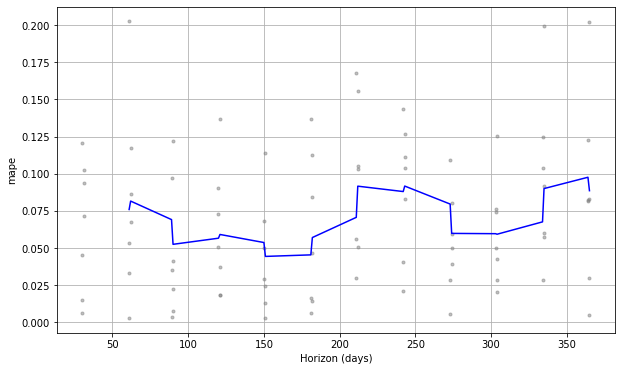

In [27]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

In [28]:
df_p.describe()

,horizon,mse,rmse,mae,mape,mdape,coverage
count,22,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,212 days 03:16:21.818181,0.906426,0.916942,0.758830,0.069973,0.063329,0.327652
std,98 days 14:31:27.112420,0.544003,0.262238,0.247832,0.016413,0.024051,0.174947
min,61 days 00:00:00,0.380328,0.616707,0.442208,0.044368,0.020503,0.031250
25%,128 days 06:00:00,0.500206,0.707232,0.589551,0.057574,0.047393,0.210938
50%,211 days 12:00:00,0.734609,0.855915,0.683958,0.068361,0.061211,0.302083
75%,295 days 18:00:00,1.070061,1.034100,0.852450,0.086383,0.080749,0.468750
max,365 days 00:00:00,2.130555,1.459642,1.298153,0.097596,0.104404,0.666667


We find a MAPE of ~6.9% with std ~1.6%. This would have estimated the error we saw on the test set to a good degree.

## Hyper-parameters

The model plot we saw earlier did not fit very well to the train data. We can change the model assumptions (like hyper-parameters) to change how well it is fitting the train data.

`Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)`

**TASK**

* Try changing some of these. [This](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3) blog is very useful in explaining the parameters and what they do.
* Find at least one change which improves your model cross validation score

In [ ]:
model = Prophet(
    yearly_seasonality='auto',weekly_seasonality=False,daily_seasonality=False,
    holidays=None,holidays_prior_scale=10.0,changepoint_prior_scale=0.05,stan_backend=None,
    mcmc_samples=0,interval_width=0.8,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10,
    uncertainty_samples=1000,
)
model.fit(train_df)
df_cv = cross_validation(model, initial='1350 days', period='365 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

In [ ]:
growth='linear',
    changepoints=None,
    n_changepoints=20,
    changepoint_range=0.8,
    changepoint_prior_scale=0.05,
    # we define our own seasonality
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10.0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None

In [157]:
#### your solution here 

# .add_seasonality(name='daily', period=1, fourier_order=15)
# .add_seasonality(name='weekly', period=7, fourier_order=20)
# .add_seasonality(name='monthly', period=30.5, fourier_order=12)
# .add_seasonality(name='yearly', period=365.25, fourier_order=20)
# .add_seasonality(name='quarterly', period=365.25/4, fourier_order=5,prior_scale=15)


prophet = Prophet(
daily_seasonality = False,
    weekly_seasonality = False,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10,
    changepoint_prior_scale=0.05,)
# ).add_seasonality(name='monthly', period=30.5, fourier_order=10
#                  ).add_seasonality(name='yearly', period=365.25, fourier_order=20
#                                   )

In [158]:
prophet.fit(train_df)
df_cv2 = cross_validation(prophet, initial='1350 days', period='365 days', horizon = '365 days')
df_cv2.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 1952-12-02 00:00:00 and 1958-12-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1953-01-01,6.226010,6.091130,6.361875,6.322581,1952-12-02
1,1953-02-01,7.586527,7.456132,7.721331,7.000000,1952-12-02
2,1953-03-01,7.413695,7.284185,7.543960,7.612903,1952-12-02
3,1953-04-01,7.235272,7.095923,7.370676,7.833333,1952-12-02
4,1953-05-01,6.926749,6.792360,7.063420,7.387097,1952-12-02


In [159]:
df_p2 = pd.DataFrame(performance_metrics(df_cv2))
df_p2.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,61 days,0.382214,0.618235,0.493041,0.061656,0.050141,0.437500
1,62 days,0.558494,0.747324,0.645965,0.073130,0.055732,0.208333
2,89 days,0.488720,0.699085,0.578259,0.065050,0.055732,0.187500
3,90 days,0.502165,0.708636,0.533470,0.052926,0.039310,0.250000
4,120 days,0.505200,0.710774,0.581786,0.061778,0.049154,0.166667


In [160]:
df_p2.describe()

,horizon,mse,rmse,mae,mape,mdape,coverage
count,22,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,212 days 03:16:21.818181,0.471836,0.684087,0.534380,0.051866,0.040898,0.322917
std,98 days 14:31:27.112420,0.087463,0.063605,0.059629,0.010637,0.014587,0.094982
min,61 days 00:00:00,0.306908,0.553993,0.461843,0.034776,0.018016,0.166667
25%,128 days 06:00:00,0.408941,0.639426,0.489128,0.044185,0.029699,0.257812
50%,211 days 12:00:00,0.481598,0.693954,0.525748,0.049170,0.037955,0.312500
75%,295 days 18:00:00,0.513658,0.716692,0.577150,0.061731,0.050452,0.406250
max,365 days 00:00:00,0.679240,0.824160,0.676548,0.073130,0.067081,0.500000


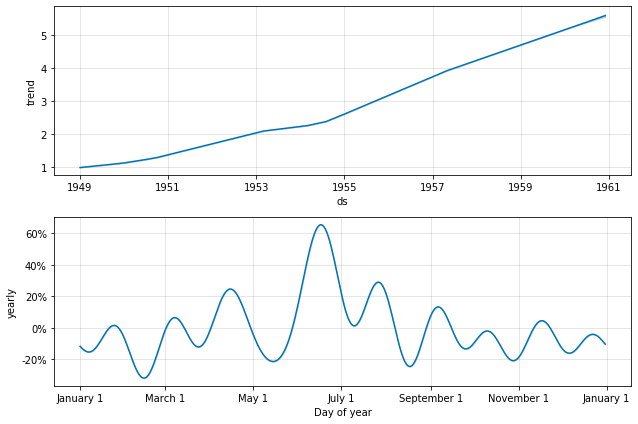

In [161]:
prophet.plot_components(forecast2);

In [136]:
# plot_cross_validation_metric(df_cv2, metric='mape');

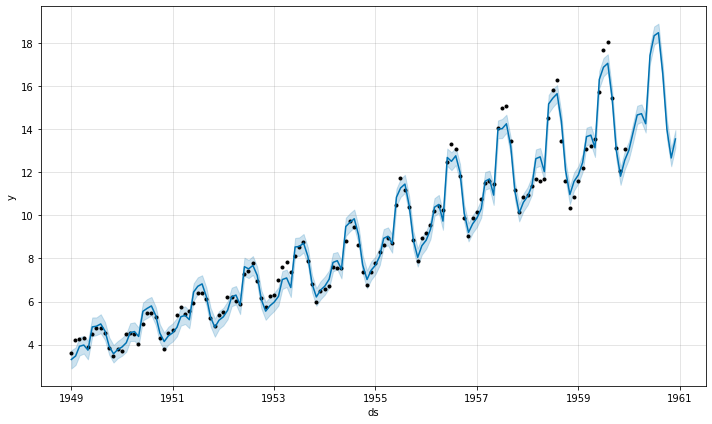

In [162]:
future2 = prophet.make_future_dataframe(periods=12, freq='M', include_history=True).apply(lambda x : x + pd.DateOffset(days = 1))
forecast2 = prophet.predict(future2)
y_pred2 = forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
fig = model.plot(forecast2)

In [163]:
mean_absolute_percentage_error(test.values , forecast2['yhat'][-12:])

4.551802349855427